University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela 

# Lecture 13: MCMC and gradients 2: Dynamic HMC and NUTS

Background reading: please see Chapter 14 of the "Course notes" available in Moodle.


## 1. NUTS

Redo the examples from Lecture 12 using the No-U-Turn Sampler of Hoffman & Gelman. How many samples do you need to get a good representation of the target density?

If you are familiar with Python, it is a good exercise to re-implement the NUTS algorithm (Algorithm 6 in Hoffman & Gelman). If you do not feel up to the task, you can use the example implementations in `autograd` and PyTorch available in Moodle in this week's material.

*Hints*: 
- To use the example code, save the file to the same directory as this notebook, and import the desired implementation using `import nuts_autograd as nuts` or `import nuts_pytorch as nuts`.
- After importing it, call the NUTS algorithm with `nuts.nuts6(...)`.
- You can use `? nuts.nuts6` to get help.

*Note*: The following solutions use `nuts_autograd`, so ensure that you have downloaded it in the same folder as this notebook.

In [1]:
# Many latter examples will use autograd so we will use autograd.numpy libraries throughout
%matplotlib inline
import autograd
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.numpy.linalg as npl
import matplotlib.pyplot as plt
import nuts_autograd as nuts

In [2]:
# Define targets and utility functions

def circle(x):
    """Circle target log pdf."""
    return -20*(np.sqrt(np.sum(x**2))-10)**2

def correlated_normal(x, rho=0.998):
    """Correlated normal target log pdf."""
    Sigma = np.array([[1.0, rho],[rho, 1.0]])
    return -0.5*(x.T @ npl.solve(Sigma, x))

def big_normal(x):
    """Big multivariate normal target log pdf."""
    return -0.5*np.sum(x**2 / (np.arange(1, 21)/20)**2)

def plot_results(samples, name='target'):
    """Plot MCMC results."""
    plt.plot(samples[:,0], samples[:,1], '.')
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
    plt.title(r'MCMC samples from the ' + name + ' distribution')
    plt.show()
    print('Mean: {}'.format(np.mean(samples, 0)))
    print('Std: {}'.format(np.std(samples, 0))) 

/home/luigi/Documents/GitHub/compstats2022/13-nuts/nuts_autograd.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  while ( (acceptprob ** a) > (2. ** (-a))):


find_reasonable_epsilon = 0.25
Final epsilon = 0.2730553380815954


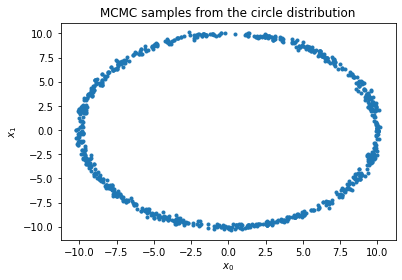

Mean: [-0.05468232 -0.43233531]
Std: [7.15967963 6.96181632]


In [3]:
# 1
samples1 = nuts.nuts6(circle, 1000, 100, np.array([6.0, 0.0]))
plot_results(samples1, 'circle')

find_reasonable_epsilon = 0.125


/home/luigi/Documents/GitHub/compstats2022/13-nuts/nuts_autograd.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  while ( (acceptprob ** a) > (2. ** (-a))):


Final epsilon = 0.07175103495933285


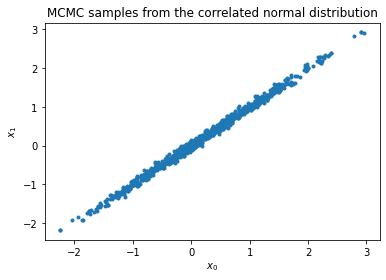

Mean: [0.21421813 0.21520589]
Std: [0.88491867 0.88320742]
Correlation coefficient rho: 0.9972942774774717


In [4]:
# 2
samples2 = nuts.nuts6(correlated_normal, 1000, 100, np.zeros(2))
plot_results(samples2, 'correlated normal')
print('Correlation coefficient rho: {}'.format(np.corrcoef(samples2.T)[0,1]))

find_reasonable_epsilon = 0.03125


/home/luigi/Documents/GitHub/compstats2022/13-nuts/nuts_autograd.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  while ( (acceptprob ** a) > (2. ** (-a))):


Final epsilon = 0.08547007115970849


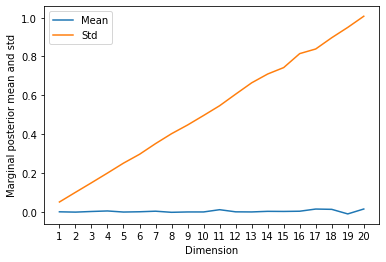

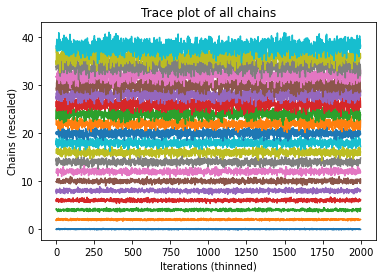

In [5]:
#3
samples3 = nuts.nuts6(big_normal, 10000, 1000, np.zeros(20))

plt.plot(np.arange(1, 21), np.mean(samples3, 0),label='Mean')
plt.plot(np.arange(1, 21), np.std(samples3, 0),label='Std')
plt.xticks(np.arange(1,21))
plt.xlabel('Dimension')
plt.ylabel('Marginal posterior mean and std')
plt.legend()
plt.show()

plt.plot(samples3[::5] + 2*np.arange(20))
plt.xlabel('Iterations (thinned)')
plt.ylabel('Chains (rescaled)')
plt.title('Trace plot of all chains')
plt.show()

## 1b. NUTS with PyTorch

find_reasonable_epsilon = 0.25
Final epsilon = 0.23820421663300306
Mean: [-0.53649795  0.2487558 ]
Std: [7.025969  7.1036735]


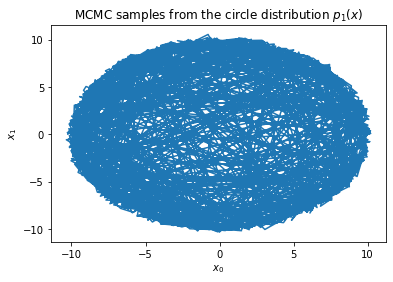

In [6]:
%matplotlib inline
import torch
import nuts_pytorch as nuts
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(nuts)

dtype = torch.double
device = torch.device("cpu")

#1
def circle_torch(x):
    return -20*(torch.sqrt(torch.sum(x**2))-10)**2

samples1 = nuts.nuts6(circle_torch, 1000, 100, torch.tensor([6.0, 0.0], device=device, dtype=dtype))
samples1 = samples1.numpy()
plt.plot(samples1[:,0], samples1[:,1])
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title(r'MCMC samples from the circle distribution $p_1(x)$')
print('Mean: {}'.format(np.mean(samples1, 0)))
print('Std: {}'.format(np.std(samples1, 0)))

find_reasonable_epsilon = 0.0625
Final epsilon = 0.07498148019709519


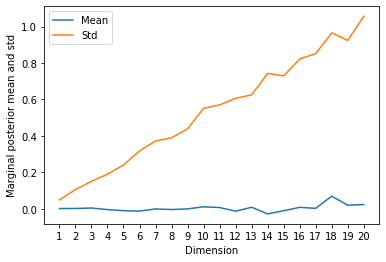

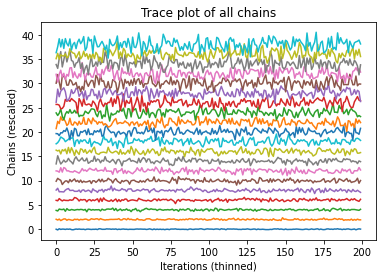

In [7]:
# 3
def big_normal_torch(x):
    return -0.5*torch.sum(x**2 / ((torch.arange(1, 21, device=device, dtype=dtype) / 20)**2))

samples3 = nuts.nuts6(big_normal_torch, 1000, 100, torch.zeros(20, device=device, dtype=dtype))
samples3 = samples3.numpy()

plt.plot(np.arange(1, 21), np.mean(samples3, 0),label='Mean')
plt.plot(np.arange(1, 21), np.std(samples3, 0),label='Std')
plt.xticks(np.arange(1,21))
plt.xlabel('Dimension')
plt.ylabel('Marginal posterior mean and std')
plt.legend()
plt.show()

plt.plot(samples3[::5] + 2*np.arange(20))
plt.xlabel('Iterations (thinned)')
plt.ylabel('Chains (rescaled)')
plt.title('Trace plot of all chains')
plt.show()

## 2. HMC and NUTS sampling from a target potential

In this exercise we will sample from a 2D density using HMC and NUTS.

The unnormalised target density is
$$ \pi^*(\boldsymbol{\theta}) = \exp\left( -20(\theta_2 - \theta_1^2 - \theta_1 - 1)^2 - \theta_1^2 \right), $$
where $\boldsymbol{\theta} = (\theta_1, \theta_2)$.

1. Run a HMC sampler on the problem and compute the means of $\theta_1$ and $\theta_2$. 
2. Run NUTS on the problem and compute the means of $\theta_1$ and $\theta_2$.
3. Compare the estimates of the means produced by the different algorithms. Run both algorithms multiple times and compute the variability of the estimates. Can you see differences where one would give more accurate results with a smaller number of samples?

*Hint*: Make sure to tune the HMC sampler properly. If you are uncertain if your estimated means are accurate enough, repeat the computation a few times and compare the results. If they are all nicely within the tolerance, you can average the results and are probably fine. If the results vary more than the tolerance, you should probably run the sampler for longer. You can use the implementation of NUTS provided in the course material.

In [8]:
%matplotlib inline
import nuts
import matplotlib.pyplot as plt

def target2(x):
    """Target log density."""
    return -20*(x[1] - x[0]**2 - x[0] -1)**2 - x[0]**2

def plot_results2(samples, algo):
    """Plot results of Exercise 2."""
    plt.plot(samples[:,0], samples[:,1], '.')
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'Target pdf samples (' + algo + ')')
    plt.show()
    print(algo + ': Mean: {} Std: {}'.format(np.mean(samples, 0), np.std(samples, 0)))

def hmc(x0, M, target, epsilon0, L):
    """Hamiltonian Monte Carlo sampler."""
    xs = np.zeros([M, len(x0)])
    gradF = autograd.grad(target)
    x = np.copy(x0)
    g = gradF(x)  # set gradient using initial x
    logP = target(x)  # set objective function too
    accepts = 0
    for m in range(2*M): # draw M samples after M warm-up iterations
        p = npr.normal(size=x.shape)  # initial momentum is Normal(0,1)
        H = p.T @ p / 2 - logP   # evaluate H(x,p)
        xnew = np.copy(x)
        gnew = np.copy(g)
        for l in range(L): # make L ‘leapfrog’ steps
            epsilon = npr.uniform(0.8, 1.2) * epsilon0  # optional: randomise epsilon for improved theoretical convergence properties
            p = p + epsilon * gnew / 2   # make half-step in p
            xnew = xnew + epsilon * p    # make step in x
            gnew = gradF(xnew)           # find new gradient
            p = p + epsilon * gnew / 2   # make half-step in p
        logPnew = target(xnew)   # find new value of H
        Hnew = p.T @ p / 2 - logPnew
        dH = Hnew - H    # Decide whether to accept
        if dH < 0 or np.log(npr.rand()) < -dH:
            g = gnew
            x = xnew
            logP = logPnew
            accepts += 1
        if m >= M:
            xs[m-M,:] = x
    print('Acceptance rate:', accepts/(2*M))
    return xs

/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: overflow encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
/tmp/ipykernel_7187/1635843849.py:36: RuntimeWarning: invalid value encountered in add
  p = p + epsilon * gnew / 2   # make half-step in p
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)
/tmp/ipykernel_7187/1635843849.py:7: RuntimeWarning: overflow encountered in double_scalars
  return -2

Acceptance rate: 0.86


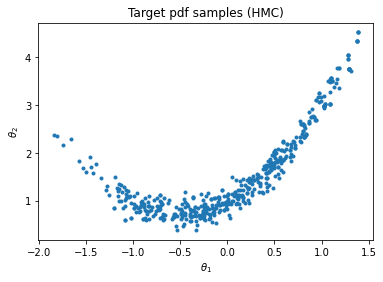

HMC: Mean: [0.04210842 1.55952592] Std: [0.72299173 0.92923221]


In [9]:
# 1 Run HMC on the target
theta0 = np.array([0.,1.])
nsamples = 500
eps0 = 0.07
L = 30
samples_hmc = hmc(theta0, nsamples, target2, eps0, L)
plot_results2(samples_hmc, 'HMC')

find_reasonable_epsilon = 0.125
Final epsilon = 0.1751437324849394


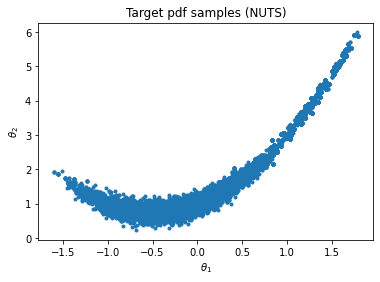

NUTS: Mean: [0.29074443 1.99047249] Std: [0.77906807 1.40556725]


In [10]:
# 2 Run NUTS on the target
warmup = 10000
nsamples = 500

samples_nuts = nuts.nuts6(target2, warmup, nsamples, theta0)
plot_results2(samples_nuts, 'NUTS')

In [11]:
# 3 Run HMC and NUTS multiple times, get statistics

# Run HMC multiple times
npr.randn(42)
nsamples = 500
eps0 = 0.07
L = 30
means = np.zeros((10, 2))
for i in range(10):
    samples = hmc(theta0, nsamples, target2, eps0, L)
    #samples = nuts.nuts6(lambda x: target4(x), 10000, 1000, np.zeros(2))
    means[i,:] = np.mean(samples, 0)
    print(np.mean(samples, 0), np.std(samples, 0))
print('HMC mean and std of the mean for {} repetitions: {}, {}.'.format(len(means), np.mean(means, 0), np.std(means, 0)))

/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)
/tmp/ipykernel_7187/1635843849.py:7: RuntimeWarning: overflow encountered in double_scalars
  return -20*(x[1] - x[0]**2 - x[0] -1)**2 - x[0]**2
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: overflow encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
/tmp/ipykernel_7187/1635843849.py:36: RuntimeWarning: invalid value encountered in add
  p = p + epsilon * gnew / 2   # make half-step in p
/home/luigi/anaconda3/envs/compstats21/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in

Acceptance rate: 0.867
[-0.04887397  1.40112683] [0.67458553 0.81421907]
Acceptance rate: 0.867
[0.10240923 1.65821255] [0.72514872 1.08151053]


/tmp/ipykernel_7187/1635843849.py:38: RuntimeWarning: overflow encountered in matmul
  Hnew = p.T @ p / 2 - logPnew


Acceptance rate: 0.851
[-0.00851647  1.47270798] [0.69249931 0.91473791]


/tmp/ipykernel_7187/1635843849.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return -20*(x[1] - x[0]**2 - x[0] -1)**2 - x[0]**2


Acceptance rate: 0.854
[-0.00550848  1.37536351] [0.61644774 0.70913939]
Acceptance rate: 0.882
[-0.01867452  1.4241098 ] [0.67763943 0.87189257]
Acceptance rate: 0.86
[-0.12064968  1.28698588] [0.62952673 0.6905973 ]
Acceptance rate: 0.873
[-0.00968512  1.43638405] [0.66751191 0.88933468]
Acceptance rate: 0.863
[0.05458318 1.60425541] [0.7386056  0.98097051]
Acceptance rate: 0.875
[-0.00823636  1.43324529] [0.67030885 0.82166203]
Acceptance rate: 0.887
[-0.00249089  1.38260607] [0.61736702 0.73663998]
HMC mean and std of the mean for 10 repetitions: [-0.00656431  1.44749974], [0.05531775 0.10383231].


In [12]:
# Run NUTS multiple times
npr.randn(42)
warmup = 10000
nsamples = 500
means = np.zeros((10, 2))
for i in range(10):
    samples = nuts.nuts6(lambda x: target2(x), warmup, nsamples, theta0)
    means[i,:] = np.mean(samples, 0)
print('NUTS mean and std of the mean for {} repetitions: {}, {}.'.format(len(means), np.mean(means, 0), np.std(means, 0)))

find_reasonable_epsilon = 0.125
Final epsilon = 0.1823039641108805
find_reasonable_epsilon = 0.125


/home/luigi/Documents/GitHub/compstats2022/13-nuts/nuts.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  while ( (acceptprob ** a) > (2. ** (-a))):


Final epsilon = 0.17249768171376176
find_reasonable_epsilon = 0.125
Final epsilon = 0.16221609807635534
find_reasonable_epsilon = 0.125
Final epsilon = 0.1789270686212786
find_reasonable_epsilon = 0.0625
Final epsilon = 0.1415029896107989
find_reasonable_epsilon = 0.0625
Final epsilon = 0.18842256219649559
find_reasonable_epsilon = 0.25
Final epsilon = 0.1793412639314296
find_reasonable_epsilon = 0.0625
Final epsilon = 0.19054659247760405
find_reasonable_epsilon = 0.0625
Final epsilon = 0.1737382428282072
find_reasonable_epsilon = 0.25
Final epsilon = 0.17932017546302154
NUTS mean and std of the mean for 10 repetitions: [0.0611781  1.65648998], [0.29546229 0.53382301].


## 3. HMC sampling for posterior inference in linear regression

Let us revisit Problem 4 from Lecture 10 where we studied linear regression using maximum likelihood estimation.
We will use data from the Framingham Heart Study that studies the association between heart disease and its causes.

A description of the data and its fields can be found at http://www.maths.utas.edu.au/DHStat/Data/Flow.html (see also problem 10.4 in the computer tasks done in class).

1. Load the data using the below code. Standardise the data by subtracting the mean and dividing each variable (both $x$ and $y$) by **two** standard deviations (see http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf). Fit all the models using the standardised data as this makes sampling a lot easier.
2. Using the same normal log-likelihood as Problem 4.2 from Lecture 10 and priors
$$ p(\alpha) = \mathcal{N}(\alpha;\; 0, 2^2) \\
  p(\beta) = \mathcal{N}(\beta;\; 0, 2^2), $$
use HMC / NUTS to draw samples from the posterior distribution. How does the posterior compare to the maximum likelihood estimates obtained at Lecture 10?
3. Change the likelihood to use the Laplace distribution for the residuals $\epsilon_i$ while keeping the same priors. Repeat the previous task.

In [15]:
import pandas as pd
import autograd.numpy as np
import autograd
from scipy.optimize import minimize
import nuts_autograd as nuts

def standardize(x):
    return (x - np.mean(x)) / (2*np.std(x))

# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')
# convert the variables of interest to numpy arrays for autograd compatibility
# input: Framingham relative weight - the ratio of the subjects weight to the median weight for their sex-height group
x = np.array(fram['FRW'])
# target: Systolic blood pressure, examination 1
y = np.array(fram['SBP'])

xs = standardize(x)
ys = standardize(y)

# 2
def linear_regression_logl(coefs, x, y):
    """Log likelihood for linear regression with normal residual."""
    return np.sum(-0.5*np.log(2*np.pi)-0.5*(y - coefs[0] - coefs[1] * x)**2)

def linear_regression(x, y):
    """Perform linear regression with normal noise model."""
    myfun = lambda c: -linear_regression_logl(c, np.array(x), np.array(y))
    dmyfun = autograd.grad(myfun)
    v = minimize(myfun, np.ones(2), jac=dmyfun)
    return v

def normal_logp(x, mu, sigma):
    """Normal log pdf."""
    return np.sum(-0.5*np.log(2*np.pi*sigma**2) - 0.5*((x-mu)**2/sigma**2))

def norm_linreg_target(theta, x, y):
    """Log target (unnormalized posterior) for linear regression with normal residual."""
    return linear_regression_logl(theta, xs, ys) + normal_logp(theta[0], 0, 2) + normal_logp(theta[1], 0, 2)

samples_norm = nuts.nuts6(lambda theta: norm_linreg_target(theta, xs, ys), 1000, 200, np.array([1.0, 0.0]))

print('\nLinear regression (normal noise):')
print('Posterior means: {}'.format(np.mean(samples_norm, 0)))
print('Posterior stds: {}'.format(np.std(samples_norm, 0)))
print('Maximum-likelihood estimate: {}'.format(linear_regression(xs, ys)['x']))

/home/luigi/Documents/GitHub/compstats2022/13-nuts/nuts_autograd.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  while ( (acceptprob ** a) > (2. ** (-a))):


find_reasonable_epsilon = 0.03125
Final epsilon = 0.04368027145484221

Linear regression (normal noise):
Posterior means: [-0.0007266   0.32907292]
Posterior stds: [0.02783954 0.05270723]
Maximum-likelihood estimate: [-1.71461174e-16  3.32017684e-01]


In [16]:
# 3
def laplace_regression_logl(coefs, x, y):
    """Log likelihood for linear regression with Laplace residual."""
    return np.sum(-np.log(2)-np.abs(y - coefs[0] - coefs[1] * x))

def laplace_regression(x, y):
    """Perform linear regression with Laplace noise model."""
    myfun = lambda c: -laplace_regression_logl(c, np.array(x), np.array(y))
    dmyfun = autograd.grad(myfun)
    v = minimize(myfun, np.ones(2), jac=dmyfun, method='L-BFGS-B')
    return v

def lap_linreg_target(theta, x, y):
    """Log target (unnormalized posterior) for linear regression with Laplace residual."""
    return laplace_regression_logl(theta, xs, ys) + normal_logp(theta[0], 0, 2) + normal_logp(theta[1], 0, 2)

samples_lap = nuts.nuts6(lambda theta: lap_linreg_target(theta, xs, ys), 1000, 200, np.array([1.0, 0.0]))

print('\nLinear regression (Laplace noise):')
print('Posterior means: {}'.format(np.mean(samples_lap, 0)))
print('Posterior stds: {}'.format(np.std(samples_lap, 0)))
print('Maximum-likelihood estimate: {}'.format(laplace_regression(xs, ys)['x']))

find_reasonable_epsilon = 0.03125
Final epsilon = 0.0311703655696403

Linear regression (Laplace noise):
Posterior means: [-0.07596613  0.31766961]
Posterior stds: [0.01955728 0.04207132]
Maximum-likelihood estimate: [-0.06968736  0.31701127]
